In [1]:
import h5py
import json
import random
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt

import pydicom
sys.path.append('./src')
import numpy as np
#from generators import DataGenerator
from generator_hamdi import DataGenerator
from models import dota_energies
from preprocessing import DataRescaler
from preprocessing_hamdi import get_scaling_factors
from tensorflow_addons.optimizers import LAMB
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.config import list_physical_devices
import json
import tensorflow as tf
print(list_physical_devices('GPU'))
from models import dota_energies
from preprocessing import DataRescaler
from evaluation import gamma_analysis, error_analysis
from tqdm import tqdm
from scipy.linalg import norm
import pymedphys



2024-03-14 06:16:07.995450: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-14 06:16:08.407230: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-14 06:16:09.665571: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-14 06:16:09.666198: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]


/home/hamdielsayed/.conda/envs/dota_electron/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [29]:
import os
import numpy as np
import pydicom

def load_data_from_directory(directory):
    data = {}

    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if filename.endswith('.npy'):
            # Load NumPy file
            var_name = filename[:-4]  # Remove '.npy' from file name
            data[var_name] = np.expand_dims(np.load(file_path),axis=(0,-1))
        elif filename.endswith('.dcm'):
            # Load DICOM file
            var_name = filename[:-4]  # Remove '.dcm' from file name
            data[var_name] = pydicom.dcmread(file_path).pixel_array*pydicom.dcmread(file_path).DoseGridScaling

    return data

directory_path = r"/home/hamdielsayed/dota/validation_dicoms"
loaded_data = load_data_from_directory(directory_path)

# Access the data like this:
# ct030_data = loaded_data['ct030'] (if ct030.npy or ct030.dcm exists)


In [8]:
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
gpu_index = 1
gpus = tf.config.experimental.list_physical_devices('GPU')
print('Available GPUs: ', gpus)
mem_growth = tf.config.experimental.get_memory_growth(gpus[gpu_index])
print('Memory growth: ', mem_growth)
if gpus:
    tf.config.experimental.set_visible_devices(gpus[gpu_index], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[gpu_index], True)
    mem_growth = tf.config.experimental.get_memory_growth(gpus[gpu_index])
    print('GPU set to be visible and memory growth set to: ', mem_growth)

Available GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
Memory growth:  None
GPU set to be visible and memory growth set to:  True


In [4]:
with open('hyperparam.json', 'r') as hfile:
    param = json.load(hfile)


path = r"/tudelft.net/staff-umbrella/simelectrons/OneGeometryMultipleEnergy"
test_df=pd.read_pickle(os.path.join(path,'test_picklefile.pkl'))

testIDs=test_df['cropped_geometry_name'].tolist()
path_weights = os.path.join(os.path.dirname(path),'weights_mpe/ckpt/weights.ckpt')

with open('scale_mpe.json', 'r') as file:
    scale_json = file.read()
scale = json.loads(scale_json)

transformer = dota_energies(
    num_tokens=param['num_tokens'],
    input_shape=param['data_shape'],
    projection_dim=param['projection_dim'],
    num_heads=param['num_heads'],
    num_transformers=param['num_transformers'], 
    kernel_size=param['kernel_size'],
    causal=True
)

# Load weights from checkpoint.
transformer.load_weights(path_weights)


In [7]:
def infer(model,path, filename, scale, ikey='GeometryAll', okey='DoseAll',df=test_df):
    """
    Get model prediction from test sample ID.
    """
    


    geometry_path=os.path.join(path,ikey,filename+'.dcm')
    tmp_geometry=np.swapaxes(pydicom.dcmread(geometry_path).pixel_array,0,2)
    geometry = np.expand_dims(tmp_geometry, axis=(0,-1))
    
    inputs = (geometry - scale['x_min']) / (scale['x_max'] - scale['x_min'])
    ground_truth_filename=df[df['cropped_geometry_name']==filename]['cropped_dose_name'].iloc[0]+'.dcm'
    ground_truth_metadata=pydicom.dcmread(os.path.join(path,okey,ground_truth_filename))
    ground_truth_array=ground_truth_metadata.pixel_array*ground_truth_metadata.DoseGridScaling
    ground_truth= np.swapaxes(ground_truth_array,0,2)
    
    energy_temp = df[df['cropped_geometry_name']==filename]['energy'].iloc[0]
    energy=(energy_temp - scale['e_min']) / (scale['e_max'] - scale['e_min'])

    
    # Predict dose distribution
    prediction = model.predict([inputs, np.expand_dims(energy, -1)],verbose=None)
    prediction = prediction * (scale['y_max']-scale['y_min']) + scale['y_min']

    return np.squeeze(geometry), np.squeeze(prediction), np.squeeze(ground_truth)


from pymedphys import gamma
def gamma_analysis(ground_truth, prediction ,cutoff,scale, dose_threshold=1, distance_threshold=3, resolution=[2,2,2]):
    """
    Performs a gamma analysis for a single instance of ground_truth and prediction.
    Optionally calculates in which part of the beam (quadrant) the failed voxels are.
    """


    # Cut off MC noise
    ground_truth[ground_truth < (cutoff/100) * scale['y_max']] = 0
    prediction[prediction < (cutoff/100) * scale['y_max']] = 0

    # Calculate gamma values.
    axes = (np.arange(ground_truth.shape[0]) * resolution[0],
            np.arange(ground_truth.shape[1]) * resolution[1],
            np.arange(ground_truth.shape[2]) * resolution[2])
    gamma_values = gamma(axes, ground_truth, axes, prediction, dose_threshold,
                         distance_threshold, lower_percent_dose_cutoff=90, max_gamma=1.1)
    gamma_values = np.nan_to_num(gamma_values, 0)

    # Calculate gamma pass rate.
    gamma_pass_rate = np.sum(gamma_values <= 1) / np.prod(gamma_values.shape)

    return gamma_pass_rate*100
def calc_relative_error(ground_truth,prediction):
    n_v=np.prod(ground_truth.shape)
    diff=ground_truth-prediction
    return (1/n_v)* (np.sqrt(np.sum(np.abs(diff)))/np.max(ground_truth)) *100

def calc_RMSE(ground_truth,prediction):
    n_v=np.prod(ground_truth.shape)

    return np.sqrt((1/n_v)* (np.sum((ground_truth-prediction)**2)))



In [2]:



def gamma_analysis(ground_truth, prediction,scale,cutoff=0.1, dose_threshold=1, distance_threshold=3, resolution=[2,2,2]):
    """
    Performs a gamma analysis for a single instance of ground_truth and prediction.
    Optionally calculates in which part of the beam (quadrant) the failed voxels are.
    """


    # Cut off MC noise
    ground_truth[ground_truth < (cutoff/100) * scale['y_max']] = 0
    prediction[prediction < (cutoff/100) * scale['y_max']] = 0

    # Calculate gamma values.
    axes = (np.arange(ground_truth.shape[0]) * resolution[0],
            np.arange(ground_truth.shape[1]) * resolution[1],
            np.arange(ground_truth.shape[2]) * resolution[2])
    gamma_values = gamma(axes, ground_truth, axes, prediction, dose_threshold,
                         distance_threshold, lower_percent_dose_cutoff=0,max_gamma=1.1)
    gamma_values = np.nan_to_num(gamma_values, 0)

    # Calculate gamma pass rate.
    gamma_pass_rate = np.sum(gamma_values <= 1) / np.prod(gamma_values.shape)

    return gamma_pass_rate*100


def calc_relative_error(ground_truth,prediction):
    n_v=np.prod(ground_truth.shape)
    diff=ground_truth-prediction
    return (1/n_v)* (np.sqrt(np.sum(np.abs(diff)))/np.max(ground_truth)) *100

def calc_RMSE(ground_truth,prediction):
    n_v=np.prod(ground_truth.shape)

    return np.sqrt((1/n_v)* (np.sum((ground_truth-prediction)**2)))



In [56]:
gamma_pass_rates=[]
relative_errors=[]
RMSEs=[]
for filename in tqdm(testIDs):
    prediction=np.load(os.path.join(path,'prediction',filename+'.npy'))
    ground_truth=np.load(os.path.join(path,'ground_truth',filename+'.npy'))
    gamma_pass_rate=gamma_analysis(ground_truth, prediction,scale)
    relative_error=calc_relative_error(ground_truth,prediction)
    RMSE=calc_RMSE(ground_truth,prediction)
    

df=pd.DataFrame({'gamma_pass_rate':gamma_pass_rates,'relative_error':relative_errors,'RMSE':RMSEs})

100%|██████████| 5143/5143 [4:18:04<00:00,  3.01s/it]  


In [11]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntSlider


path = r"/tudelft.net/staff-umbrella/simelectrons/OneGeometryMultipleEnergy"
test_df=pd.read_pickle(os.path.join(path,'test_picklefile.pkl'))

testIDs=test_df['cropped_geometry_name'].tolist()
idx=random.randint(0,len(testIDs))
filename=testIDs[idx]

print(test_df['energy'].iloc[idx])

#geometry,prediction, ground_truth =infer(transformer,path,testIDs[idx],scale)
geometry=np.load(os.path.join(path,'geometry',filename+'.npy'))
prediction=np.load(os.path.join(path,'prediction',filename+'.npy'))
ground_truth=np.load(os.path.join(path,'ground_truth',filename+'.npy'))

slice_index = 34

# Adjustments to prediction and ground_truth for visualization purposes
prediction = prediction * (1e9 / 1e5)
ground_truth = ground_truth * (1e9 / 1e5)

# Calculate vmin and vmax across both ground_truth and prediction for consistent scaling
vmin = min(ground_truth[:, slice_index, :].min(), prediction[:, slice_index, :].min())
vmax = max(ground_truth[:, slice_index, :].max(), prediction[:, slice_index, :].max())





def plot_slices(slice_index):
    fig, axs = plt.subplots(1, 4, figsize=(24, 6))  # Adjusted for 4 subplots
        
    # First subplot - Geometry and Prediction
    img1 = axs[0].imshow(geometry[:, slice_index, :], cmap='gray', alpha=1)
    img2 = axs[0].imshow(prediction[:, slice_index, :], cmap='turbo', alpha=0.5, vmin=vmin, vmax=vmax)
    axs[0].set_title('Geometry and Prediction')
    cbar1 = fig.colorbar(img2, ax=axs[0], fraction=0.046, pad=0.04)
    cbar1.set_label('Gy/10^9 Particles')

    # Second subplot - Error Map with geometry included
    prediction_slice = prediction[:, slice_index, :].copy()
    ground_truth_slice = ground_truth[:, slice_index, :].copy()

    zero_out_value = 0.01
    ground_truth_slice[ground_truth_slice < zero_out_value * ground_truth.max()] = 0

    error = abs(prediction_slice - ground_truth_slice) * 100 / ground_truth_slice
    error_correct = np.nan_to_num(error, nan=0.0, posinf=0.0, neginf=0.0)
    error_correct[error_correct == 0] = np.nan

    print(f" max= {np.nanmax(error_correct)}")
    axs[1].imshow(geometry[:,30:38,:].sum(axis=1), cmap='gray', alpha=1)
    img4 = axs[1].imshow(error_correct, cmap='coolwarm', alpha=0.5)
    axs[1].set_title('Error Map')
    cbar2 = fig.colorbar(img4, ax=axs[1], fraction=0.046, pad=0.04)
    cbar2.set_label('% Error')

    # Third subplot - Geometry and Ground Truth
    img5 = axs[2].imshow(geometry[:, slice_index, :], cmap='gray', alpha=1)
    img6 = axs[2].imshow(ground_truth[:, slice_index, :], cmap='turbo', alpha=0.5, vmin=vmin, vmax=vmax)
    axs[2].set_title('Geometry and Ground Truth')
    cbar3 = fig.colorbar(img6, ax=axs[2], fraction=0.046, pad=0.04)
    cbar3.set_label('Gy/10^9 Particles')

    # Fourth subplot - Absolute Difference between Ground Truth and Prediction with Geometry
    absolute_difference = prediction[:, slice_index, :]-ground_truth[:, slice_index, :]
    
    absolute_difference[absolute_difference < 0.01 * absolute_difference.max()]=np.nan
    img7 = axs[3].imshow(geometry[:, slice_index, :], cmap='gray', alpha=1)
    img8 = axs[3].imshow(absolute_difference, cmap='coolwarm', alpha=0.5)
    axs[3].set_title('Difference')
    cbar4 = fig.colorbar(img8, ax=axs[3], fraction=0.046, pad=0.04)
    cbar4.set_label('Difference')

    plt.tight_layout()
    
    plt.show()

interactive_plot = interactive(plot_slices, slice_index=(0, geometry.shape[1]-1))
relative_error=calc_relative_error(ground_truth,prediction)
print(relative_error)
interactive_plot


166.11511072449457


0.0013850506087055646


interactive(children=(IntSlider(value=33, description='slice_index', max=67), Output()), _dom_classes=('widget…

In [46]:
testIDs=test_df['cropped_geometry_name'].tolist()
cutoff=10
relative_errors=[]
RMSEs=[]
gamma_pass_rates=[]
for i in tqdm(range(len(testIDs))):

    geometry,   prediction, ground_truth =infer(transformer,path,testIDs[i],scale)
    relative_error=calc_relative_error(ground_truth,prediction)
    gamma_pass_rate=gamma_analysis(ground_truth, prediction ,cutoff, scale, dose_threshold=1, distance_threshold=3, resolution=[2,2,2])
    RMSE=calc_RMSE(ground_truth,prediction)
    relative_errors.append(relative_error)
    RMSEs.append(RMSE)
    gamma_pass_rates.append(gamma_pass_rate)

100%|██████████| 5143/5143 [1:50:11<00:00,  1.29s/it]  


In [22]:
x=np.ones((3,3))*100

y=np.ones((3,3))*2*100

calc_RMSE(x,y)

100.0

In [3]:
import pandas as pd

df=pd.read_csv('results.csv')
df



descriptive_stats = df[['relative_error', 'RMSE', 'gamma_pass_rate']].describe().loc[['mean', 'max', 'min', 'std']]

descriptive_stats

,relative_error,RMSE,gamma_pass_rate
mean,0.120818,2.801664e-07,99.985495
max,0.241637,1.473378e-06,100.000000
min,0.098856,7.712147e-08,99.516148
std,0.010975,1.565782e-07,0.017506


<h1> Descriptive Statistics 

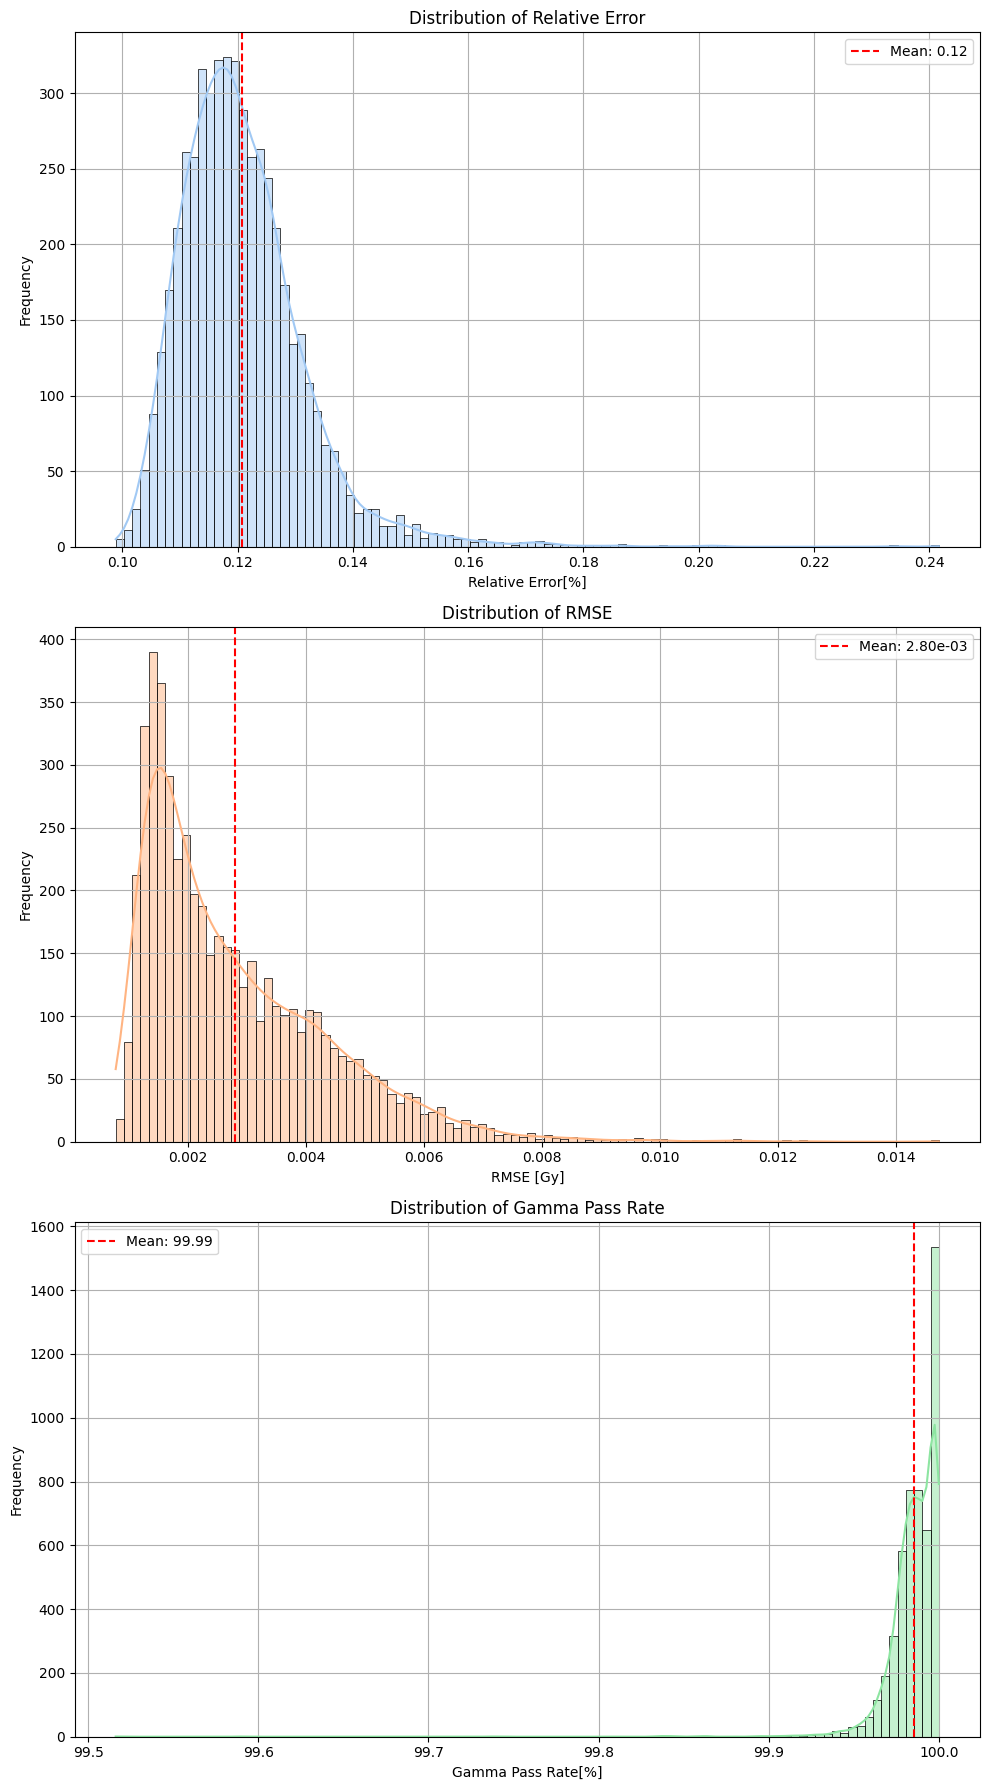

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the style and context for the plots to make them publication-quality
#sns.set(style="whitegrid", palette="pastel", context="talk", font_scale=1.2)

# Creating a figure with 3 subplots (vertically arranged)
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# Titles for each subplot
titles = ['Distribution of Relative Error', 'Distribution of RMSE', 'Distribution of Gamma Pass Rate']
axes_title=['Relative Error[%]','RMSE [Gy]','Gamma Pass Rate[%]']

# Plotting each metric's distribution
for i, col in enumerate(['relative_error', 'RMSE', 'gamma_pass_rate']):
    sns.histplot(df[col], ax=axes[i], kde=True, bins=100, color=sns.color_palette("pastel")[i])
    axes[i].set_title(titles[i])
    axes[i].set_xlabel(axes_title[i])
    axes[i].set_ylabel('Frequency')
    # Adding a vertical line for the mean
    mean_val = df[col].mean()
    if mean_val < 1e-2:
        axes[i].axvline(mean_val, color='r', linestyle='--', label=f'Mean: {mean_val:.2e}')
    else:
        axes[i].axvline(mean_val, color='r', linestyle='--', label=f'Mean: {mean_val:.2f}')
    axes[i].legend()
    axes[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()


| Statistic             | Relative Error (%) | RMSE [Gy/10^9 particles] | Gamma Pass Rate [%] |
|-----------------------|----------------|--------|-----------------|
| **Mean**              | 0.120818         | 2.801664e-03 | 99.985495
| **Max**               | 0.241637	         | 1.473378e-02	 | 100.000000         |
| **Min**               | 0.098856         | 7.712147e-04 | 99.516148          |
| **Standard Deviation**| 0.010975	         | 1.565782e-03 | 0.017506        |


In [4]:
RMSEs=pd.read_csv('results.csv')['RMSE'].tolist()
relative_errors=pd.read_csv('results.csv')['relative_error'].tolist()
gamma_pass_rates=pd.read_csv('results.csv')['gamma_pass_rate'].tolist()

def find_indices(arr):
    sorted_indices = np.argsort(arr)
    lowest_index = sorted_indices[0]
    highest_index = sorted_indices[-1]
    median_index = sorted_indices[len(arr) // 2]
    return lowest_index, highest_index, median_index

lowest_relative_error, highest_relative_error, median_relative_error = find_indices(np.array(relative_errors))
lowest_RMSE, highest_RMSE, median_RMSE = find_indices(np.array(RMSEs))
lowest_gamma_pass_rate, highest_gamma_pass_rate, median_gamma_pass_rate = find_indices(np.array(gamma_pass_rates))

print(lowest_relative_error, highest_relative_error, median_relative_error)
print(lowest_RMSE, highest_RMSE, median_RMSE)
print(lowest_gamma_pass_rate, highest_gamma_pass_rate, median_gamma_pass_rate)

2823 2117 181
416 2117 4462
2308 1396 3221


<h1> KEY METRIC EXAMPLES <h1>

In [6]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


path = r"/tudelft.net/staff-umbrella/simelectrons/OneGeometryMultipleEnergy"
test_df=pd.read_pickle(os.path.join(path,'test_picklefile.pkl'))

testIDs=test_df['cropped_geometry_name'].tolist()

# Define interactive widgets
metric_selector = widgets.Dropdown(
    options=['Gamma Pass Rate', 'RMSE', 'Relative Error'],
    value='Gamma Pass Rate',
    description='Metric:',
)

statistic_selector = widgets.Dropdown(
    options=['Lowest', 'Highest', 'Median'],
    value='Lowest',
    description='Statistic:',
)

slice_slider = widgets.IntSlider(
    value=34, 
    min=0, 
    max=67, 
    step=1, 
    description='Slice:',
)


def plot_images(metric, statistic, slice_index):

    if metric == 'Gamma Pass Rate':
        data_list = gamma_pass_rates
    elif metric == 'RMSE':
        data_list = RMSEs
    elif metric == 'Relative Error':
        data_list = relative_errors
    
    # Convert list to numpy array and find indices
    data_array = np.array(data_list)
    lowest_index, highest_index, median_index = find_indices(data_array)
    
    if statistic == 'Lowest':
        index = lowest_index
    elif statistic == 'Highest':
        index = highest_index
    elif statistic == 'Median':
        index = median_index


    
    filename=testIDs[index]

    geometry=np.load(os.path.join(path,'geometry',filename+'.npy'))
    prediction=np.load(os.path.join(path,'prediction',filename+'.npy'))
    ground_truth=np.load(os.path.join(path,'ground_truth',filename+'.npy'))

    prediction = prediction * (1e9 / 1e5)
    ground_truth = ground_truth * (1e9 / 1e5)

# Calculate vmin and vmax across both ground_truth and prediction for consistent scaling
    vmin = min(ground_truth[:, slice_index, :].min(), prediction[:, slice_index, :].min())
    vmax = max(ground_truth[:, slice_index, :].max(), prediction[:, slice_index, :].max())


    fig, axs = plt.subplots(1, 4, figsize=(24, 6))  # Adjusted for 4 subplots
        
    # First subplot - Geometry and Prediction
    img1 = axs[0].imshow(geometry[:, slice_index, :], cmap='gray', alpha=1)
    img2 = axs[0].imshow(prediction[:, slice_index, :], cmap='turbo', alpha=0.5, vmin=vmin, vmax=vmax)
    axs[0].set_title('Geometry and Prediction')
    cbar1 = fig.colorbar(img2, ax=axs[0], fraction=0.046, pad=0.04)
    cbar1.set_label('Gy/10^9 Particles')

    # Second subplot - Error Map with geometry included
    prediction_slice = prediction[:, slice_index, :].copy()
    ground_truth_slice = ground_truth[:, slice_index, :].copy()

    zero_out_value = 0.01
    ground_truth_slice[ground_truth_slice < zero_out_value * ground_truth.max()] = 0

    error = abs(prediction_slice - ground_truth_slice) * 100 / ground_truth_slice
    error_correct = np.nan_to_num(error, nan=0.0, posinf=0.0, neginf=0.0)
    error_correct[error_correct == 0] = np.nan
    print(np.nanmean(error_correct))

    axs[1].imshow(geometry[:,30:38,:].sum(axis=1), cmap='gray', alpha=1)
    img4 = axs[1].imshow(error_correct, cmap='coolwarm', alpha=0.5)
    axs[1].set_title('Error Map')
    cbar2 = fig.colorbar(img4, ax=axs[1], fraction=0.046, pad=0.04)
    cbar2.set_label('% Error')

    # Third subplot - Geometry and Ground Truth
    img5 = axs[2].imshow(geometry[:, slice_index, :], cmap='gray', alpha=1)
    img6 = axs[2].imshow(ground_truth[:, slice_index, :], cmap='turbo', alpha=0.5, vmin=vmin, vmax=vmax)
    axs[2].set_title('Geometry and Ground Truth')
    cbar3 = fig.colorbar(img6, ax=axs[2], fraction=0.046, pad=0.04)
    cbar3.set_label('Gy/10^9 Particles')

    # Fourth subplot - Absolute Difference between Ground Truth and Prediction with Geometry
    absolute_difference = prediction[:, slice_index, :]-ground_truth[:, slice_index, :]
    
    absolute_difference[absolute_difference < 0.01 * absolute_difference.max()]=np.nan
    img7 = axs[3].imshow(geometry[:, slice_index, :], cmap='gray', alpha=1)
    img8 = axs[3].imshow(absolute_difference, cmap='coolwarm', alpha=0.5)
    axs[3].set_title('Difference')
    cbar4 = fig.colorbar(img8, ax=axs[3], fraction=0.046, pad=0.04)
    cbar4.set_label('Difference (Gy/10^9 Particles)')

    plt.tight_layout()
    plt.show()


    
interactive_plot = widgets.interactive(plot_images, metric=metric_selector, statistic=statistic_selector, slice_index=slice_slider)
display(interactive_plot)


interactive(children=(Dropdown(description='Metric:', options=('Gamma Pass Rate', 'RMSE', 'Relative Error'), v…

/tmp/ipykernel_555362/3794479584.py:75: DeprecationWarning: Parameter `quiet` will be deprecated in the future
  gamma(axes, ground_truth, axes, outputs, dose_threshold,


KeyboardInterrupt: 

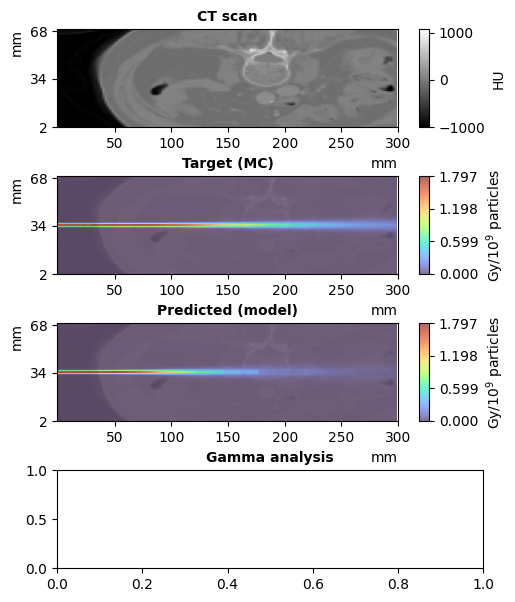

In [32]:
def plot_slice(inputs, ground_truth, outputs, dose_threshold=1,
    distance_threshold=3, cutoff=0, figsize=(5.5,7), fontsize=10,
    resolution=[2,2,2], gamma_slice=True, savefig=False):
    """
    Plots slices of the full beam along the Z axis.
    *inputs..........3D array [Y,X,Z] from function infer
    """
    # Initialize figure and axes.
    fig, axs = plt.subplots(4, 1, figsize=figsize)
    axs[0].set_title("CT scan", fontsize=fontsize, fontweight='bold')
    axs[1].set_title("Target (MC)", fontsize=fontsize, fontweight='bold')
    axs[2].set_title("Predicted (model)", fontsize=fontsize, fontweight='bold')
    if gamma_slice:
        axs[3].set_title("Gamma analysis", fontsize=fontsize, fontweight='bold')
    else:
        axs[3].set_title("Dose difference", fontsize=fontsize, fontweight='bold')
    plt.subplots_adjust(hspace=0.5, wspace=0.05)

    ground_truth=ground_truth* (1e9 / 1e5)
    outputs=outputs* (1e9 / 1e5)
    
    # Cut off MC noise

    # Calculate maximum and minimum per column.
    min_input, max_input = np.min(inputs), np.max(inputs)
    min_output, max_output = np.min(outputs), np.max(outputs)
    slice_number = int(np.floor(ground_truth.shape[-1]/2))
    cb_ticks=np.linspace(0, max_output, num=4)
    # 1st row: input values
    cbh0 = axs[0].imshow(np.transpose(inputs[:,:,slice_number]), aspect='auto',
        cmap='gray', vmin=min_input, vmax=max_input)
    plt.sca(axs[0])
    plt.yticks([68,34,1], ['2','34','68'], fontsize=fontsize)
    plt.xticks([25, 50, 75, 100, 125, 150], ['50', '100', '150', '200', '250', '300'], fontsize=fontsize)
    axs[0].set_ylabel("mm", loc='top', fontsize=fontsize)
    axs[0].set_xlabel("mm", loc='right', fontsize=fontsize)
    cb0 = fig.colorbar(cbh0, ax=axs[0], aspect=fontsize)
    cb0.ax.set_ylabel("HU", size=fontsize)
    cb0.ax.tick_params(labelsize=fontsize)

    # 2nd row: ground truth
    axs[1].imshow(np.transpose(inputs[:,:,slice_number]), aspect='auto',
        cmap='gray', alpha=0.4, vmin=min_input, vmax=max_input)
    cbh1 = axs[1].imshow(np.transpose(ground_truth[:,:,slice_number]), aspect='auto',
        cmap='turbo', alpha=0.6, vmin=min_output, vmax=max_output)
    plt.sca(axs[1])
    plt.yticks([68,34,1], ['2','34','68'], fontsize=fontsize)
    plt.xticks([25, 50, 75, 100, 125, 150], ['50', '100', '150', '200', '250', '300'], fontsize=fontsize)
    axs[1].set_ylabel("mm", loc='top', fontsize=fontsize)
    axs[1].set_xlabel("mm", loc='right', fontsize=fontsize)
    cb1 = fig.colorbar(cbh1, ax=axs[1], aspect=fontsize,ticks=cb_ticks)
    cb1.ax.set_ylabel(r"Gy/$10^9$ particles", size=fontsize)
    cb1.ax.tick_params(labelsize=fontsize)

    # 3rd row: model prediction
    axs[2].imshow(np.transpose(inputs[:,:,slice_number]), aspect='auto',
        cmap='gray', alpha=0.4, vmin=min_input, vmax=max_input)
    cbh2 = axs[2].imshow(np.transpose(outputs[:,:,slice_number]), aspect='auto', 
        cmap='turbo', alpha=0.6, vmin=min_output, vmax=max_output)
    plt.sca(axs[2])
    plt.yticks([68,34,1], ['2','34','68'], fontsize=fontsize)
    plt.xticks([25, 50, 75, 100, 125, 150], ['50', '100', '150', '200', '250', '300'], fontsize=fontsize)
    axs[2].set_ylabel("mm", loc='top', fontsize=fontsize)
    axs[2].set_xlabel("mm", loc='right', fontsize=fontsize)
    cb2 = fig.colorbar(cbh2, ax=axs[2], aspect=fontsize, ticks=cb_ticks)
    cb2.ax.set_ylabel(r"Gy/$10^9$ particles", size=fontsize)
    cb2.ax.tick_params(labelsize=fontsize)

    # 4th row: difference or gamma analysis results
    if gamma_slice:
        axes = (np.arange(ground_truth.shape[0])*resolution[0],
            np.arange(ground_truth.shape[1])*resolution[1],
            np.arange(ground_truth.shape[2])*resolution[2])
        gamma_values = np.nan_to_num(
            gamma(axes, ground_truth, axes, outputs, dose_threshold,
            distance_threshold, lower_percent_dose_cutoff=0.1, quiet=True), 0)
        axs[3].imshow(np.transpose(inputs[:,:,slice_number]), aspect='auto',
            cmap='gray', alpha=0.4, vmin=min_input, vmax=max_input)
        cbh3 = axs[3].imshow(np.transpose(np.absolute(gamma_values[:,:,slice_number])),
            aspect='auto', alpha=0.6, vmin=0, vmax=2, cmap='RdBu')

    else:
        axs[3].imshow(np.transpose(inputs[:,:,slice_number]), aspect='auto',
            cmap='gray', alpha=0.4, vmin=min_input, vmax=max_input)
        cbh3 = axs[3].imshow(np.transpose(np.absolute(
            ground_truth[:,:,slice_number]-outputs[:,:,slice_number])),
            aspect='auto', cmap='turbo', alpha=0.6, vmin=min_output, vmax=max_output)
        
    plt.sca(axs[3])
    plt.yticks([68,34,1], ['2','34','68'], fontsize=fontsize)
    plt.xticks([25, 50, 75, 100, 125, 150], ['50', '100', '150', '200', '250', '300'], fontsize=fontsize)
    axs[3].set_ylabel("mm", loc='top', fontsize=fontsize)
    axs[3].set_xlabel("mm", loc='right', fontsize=fontsize)
    cb3 = fig.colorbar(cbh3, ax=axs[3], aspect=fontsize,ticks=cb_ticks)
    if gamma_slice:
        cb3.ax.set_ylabel(r"$\gamma$ value", size=fontsize)
    else:
        cb3.ax.set_ylabel(r"Gy/$10^9$ particles", size=fontsize)
    cb3.ax.tick_params(labelsize=fontsize)
        
    if savefig:
        plt.savefig(time.strftime('%Y%m%d-%H%M'), dpi=300, bbox_inches='tight') 

    plt.show()


index=2117
filename=testIDs[index]

geometry=np.load(os.path.join(path,'geometry',filename+'.npy'))
prediction=np.load(os.path.join(path,'prediction',filename+'.npy'))
ground_truth=np.load(os.path.join(path,'ground_truth',filename+'.npy'))

prediction = prediction 
ground_truth = ground_truth 

plot_slice(geometry, ground_truth, prediction)

In [29]:
from pymedphys import gamma
def gamma_analysis(ground_truth, prediction,scale,cutoff=10, dose_threshold=1, distance_threshold=3, resolution=[2,2,2]):
    """
    Performs a gamma analysis for a single instance of ground_truth and prediction.
    Optionally calculates in which part of the beam (quadrant) the failed voxels are.
    """


    print(ground_truth.max())
    print(scale['y_max'])
    print(prediction.max())
    ground_truth[ground_truth < (cutoff/100) * ground_truth.max()] = 0
    prediction[prediction < (cutoff/100) * prediction.max()] = 0

    # Calculate gamma values.
    axes = (np.arange(ground_truth.shape[0]) * resolution[0],
            np.arange(ground_truth.shape[1]) * resolution[1],
            np.arange(ground_truth.shape[2]) * resolution[2])
    gamma_values = gamma(axes, ground_truth, axes, prediction, dose_threshold,
                         distance_threshold, lower_percent_dose_cutoff=90,max_gamma=2)
    gamma_values = np.nan_to_num(gamma_values, 0)

    # Calculate gamma pass rate.
    gamma_pass_rate = np.zeros(2)
    gamma_pass_rate[0] = 1-(np.count_nonzero(gamma_values>1)/np.count_nonzero(gamma_values>0))
    gamma_pass_rate[1] = np.sum(gamma_values<=1)/np.prod(gamma_values.shape)

    return gamma_pass_rate


gamma_values,gpr=gamma_analysis(ground_truth, prediction,scale)

0.00017700390042532386
0.00017625163603728893
0.00017966171


In [30]:
print(gpr)

0.9998774509803922


In [12]:
metric='RMSE'
statistic='Highest'
if metric == 'Gamma Pass Rate':
    data_list = gamma_pass_rates
elif metric == 'RMSE':
    data_list = RMSEs
elif metric == 'Relative Error':
    data_list = relative_errors

# Convert list to numpy array and find indices
data_array = np.array(data_list)
lowest_index, highest_index, median_index = find_indices(data_array)

if statistic == 'Lowest':
    index = lowest_index
elif statistic == 'Highest':
    index = highest_index
elif statistic == 'Median':
    index = median_index



filename=testIDs[index]

geometry=np.load(os.path.join(path,'geometry',filename+'.npy'))
prediction=np.load(os.path.join(path,'prediction',filename+'.npy'))
ground_truth=np.load(os.path.join(path,'ground_truth',filename+'.npy'))

<h1> ERROR ANALYSIS NOISE </h1>

In [10]:

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntSlider
import ipywidgets as widgets


idx=np.random.randint(0,len(testIDs))
path = r"/tudelft.net/staff-umbrella/simelectrons/OneGeometryMultipleEnergy"
test_df=pd.read_pickle(os.path.join(path,'test_picklefile.pkl'))

testIDs=test_df['cropped_geometry_name'].tolist()
#idx=random.randint(0,len(testIDs))
filename=testIDs[idx]

print(test_df['energy'].iloc[idx])

#geometry,prediction, ground_truth =infer(transformer,path,testIDs[idx],scale)
prediction=np.load(os.path.join(path,'prediction',filename+'.npy'))
ground_truth=np.load(os.path.join(path,'ground_truth',filename+'.npy'))



prediction_sum=prediction.sum(axis=2)*(1e9/1e5)
ground_truth_sum=ground_truth.sum(axis=2)*(1e9/1e5)

def plot_comparison(index):
    plt.figure(figsize=(10, 6))
    plt.plot(prediction_sum[index,:], label='Prediction')
    plt.plot(ground_truth_sum[index,:], label='Ground Truth')
    plt.title(f'Prediction vs Ground Truth at x = {index*0.2:.2f} cm ')
    plt.xlabel('Index')
    plt.ylabel('Gy/10^9 Particles')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create a slider to choose the feature index
slider = IntSlider(value=34, min=0, max=prediction_sum.shape[0]-1, step=1, description='Feature Index')

# Create an interactive widget
interactive_plot = interactive(plot_comparison, index=slider)
output = interactive_plot.children[-1]

interactive_plot

121.49678253803947


interactive(children=(IntSlider(value=34, description='Feature Index', max=149), Output()), _dom_classes=('wid…